In [1]:
%run _common.ipynb
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from neuralconstitutive.constitutive import FromLogDiscreteSpectrum
from neuralconstitutive.relaxation_spectrum import HonerkampWeeseBimodal
from neuralconstitutive.pyRespect import estimate_continous_spectrum
from neuralconstitutive.jax.tipgeometry import Spherical
from neuralconstitutive.trajectory import Trajectory, make_triangular
from neuralconstitutive.jax.ting import force_approach, force_retract

2023-11-27 13:12:05.037481: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 1. Mock data generation

We use the bimodal log-Gaussian model first introduced in J. Honerkamp and J. Weese, Macromolecules (1989).

We plot the spectrum below:

Text(0, 0.5, 'Relaxation Spectrum H(τ)[Pa]')

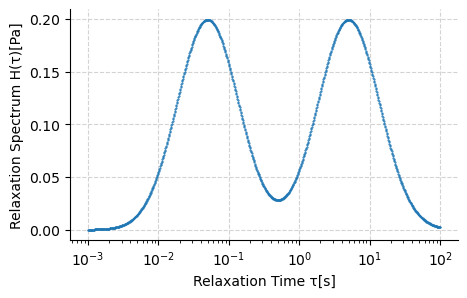

In [2]:
bimodal = FromLogDiscreteSpectrum(HonerkampWeeseBimodal())

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(*bimodal.discrete_spectrum, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")

Given a sufficiently densely sampled relaxation spectrum $\{\tau_i, h_i\}_{i=0}^N$, where $h_i = H(\tau=\tau_i)$,

the relaxation function can be approximated by the following equation:
\begin{equation}
G(t) = \sum_{i=0}^N g_i e^{-t/\tau_i}; \quad g_i = h_i\cdot h_0
\end{equation}
where $h_0 = \frac{\log(\tau_N)-\log(\tau_0)}{N}$

Text(0, 0.5, 'Relaxation Function[Pa]')

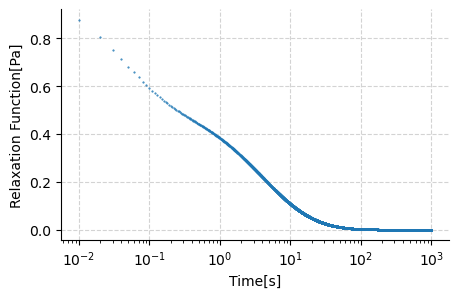

In [3]:
t_data = np.linspace(0, 1e3, 100000)[1:]  # to avoid t=0
g_data = bimodal.relaxation_function(t_data)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t_data, g_data, ".")
ax.set_xscale("log", base=10)
ax.set_xlabel("Time[s]")
ax.set_ylabel("Relaxation Function[Pa]")

## 2. Run pyRespect on the mock data

Here, we run our refactored version of pyRespect on the mock data.

The original pyRespect code first interpolates the data points onto 100 log-equi-spaced grid points before the main algorithm.

Here, the code has been tweaked so that either the interpolation can be turned off, or the number of grid points be changed.

However, note that too many time points can result in a memory overflow error (or greatly slow down the algorithm). 

Interpolating t, G to 100 points
Interpolating t, G to 200 points
Interpolating t, G to 500 points


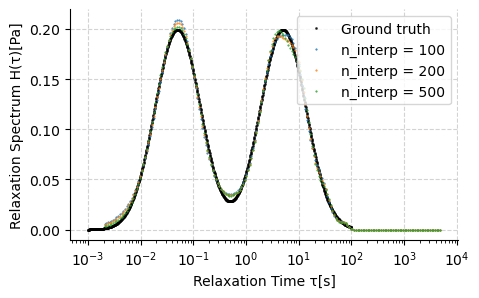

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(
    *bimodal.discrete_spectrum,
    ".",
    color="black",
    markersize=2.0,
    alpha=0.7,
    label="Ground truth",
)
for n_interp in (100, 200, 500):
    t_estimated, h_estimated, _ = estimate_continous_spectrum(
        t_data, g_data, n_interpolation=n_interp, n_spectrum_points=200
    )
    ax.plot(
        t_estimated,
        h_estimated,
        ".",
        alpha=1.0,
        label=f"n_interp = {n_interp}",
    )
ax.set_xscale("log", base=10)
ax.set_xlabel("Relaxation Time τ[s]")
ax.set_ylabel("Relaxation Spectrum H(τ)[Pa]")
ax.legend()

## 3. Calculate force curve corresponding to the mock data

In [6]:
## TODO: write convenience functions to generate triangular trajectories
tip = Spherical(1.0)
Dt = 1e-2
app, ret = make_triangular(1.0, 1e-2, 10.0)

f_app = force_approach(app, bimodal.relaxation_function, tip)
f_ret = force_retract(app, ret, bimodal.relaxation_function, tip)

Text(0.5, 0, 'Time')

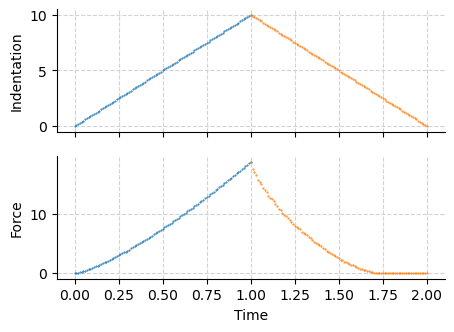

In [8]:
fig, axes = plt.subplots(2, 1, figsize = (5, 3.5), sharex = True)
axes[0].plot(app.t, app.z(app.t), ".")
axes[0].plot(ret.t, ret.z(ret.t), ".")
axes[0].set_ylabel("Indentation")

axes[1].plot(app.t, f_app, ".")
axes[1].plot(ret.t, f_ret, ".")
axes[1].set_ylabel("Force")
axes[1].set_xlabel("Time")